In [5]:
from random import gauss
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import math
import tensorflow as tf
import pandas as pd
from random import *

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
sim=5000#On choisit le nombre de simulation (on va prendre la moitié normal et la moitié anormale)
sim_normale=2500
sim_anormale=2500
a =[None for x in range(sim)] 
#simulation normal
for i in range(sim_normale):
    N_ev=np.random.poisson(1000)
    t=np.random.uniform(0,3600,N_ev)
    bins = [x for x in range(0, 3600, 100)]
    n, bins, patches = ax.hist(t, bins) #n is height of the bins
    b=list(n)
    b.append(1)
    a[i]=b
    plt.close(fig)


In [12]:
#simulation anormale
for z in range(sim_anormale):
    N_ev=np.random.poisson(1000)
    t=np.random.uniform(0,3600,N_ev)
    nombre_anomalie_gauss=randint(1, 5)#On choisit le nombre d'anomalie
    t_anomalie=[None for x in range(nombre_anomalie_gauss)] #On choisit quand se passe l'anomalie (moyenne de la gaussienne)
    for i in range(len(t_anomalie)):
        t_anomalie[i]=randint(1,3600)

    long_flare=[None for x in range(nombre_anomalie_gauss)]  #On choisit la longueur du flare (écart type)
    for i in range(len(t_anomalie)):
        long_flare[i]=randint(1,20)
    
    N_ev_anomalie=[None for x in range(nombre_anomalie_gauss)] #On choisit le nombre d'événement de l'anomalie
    for i in range(len(t_anomalie)):
        N_ev_anomalie[i]=randint(10,20)


    anomalie_gauss = [None for x in range(nombre_anomalie_gauss)]
    t_finale=[None for x in range(nombre_anomalie_gauss)]

    for j in range(len(t_anomalie)):
        if j==0:
            anomalie_gauss[j]=[gauss(t_anomalie[j],long_flare[j]) for i in range(N_ev_anomalie[j])]
            t_finale[j]=np.append(t,anomalie_gauss[j])
        else:
            anomalie_gauss[j]=[gauss(t_anomalie[j],long_flare[j]) for i in range(N_ev_anomalie[j])]
            t_finale[j]=np.append(t_finale[j-1],anomalie_gauss[j])
        
    bins = [x for x in range(0, 3600, 100)]
    n, bins, patches = ax.hist(t_finale[nombre_anomalie_gauss-1], bins)
    plt.close(fig)
    d=list(n)
    d.append(0)
    a[z+sim_normale]=d

In [13]:
c=np.array(a)
# The last element contains the labels
labels = c[:, -1]

# The other data points are the data
data = c[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

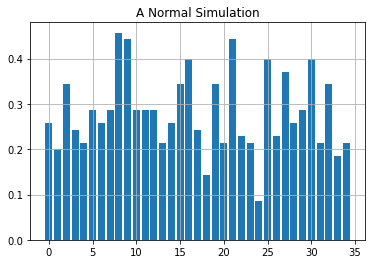

In [14]:
plt.grid()
plt.bar(np.arange(35), normal_train_data[0])
plt.title("A Normal Simulation")
plt.show()

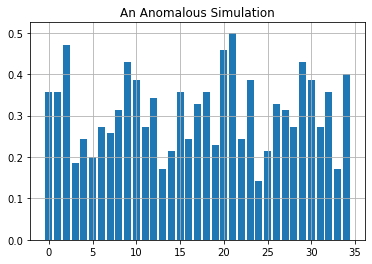

In [15]:
plt.grid()
plt.bar(np.arange(35), anomalous_train_data[0])
plt.title("An Anomalous Simulation")
plt.show()

In [16]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(35, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [17]:
autoencoder.compile(optimizer='adam', loss='mae')

In [18]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
4/4 [==============================] - 2s 121ms/step - loss: 0.2180 - val_loss: 0.2096
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.2155 - val_loss: 0.2071
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 0.2128 - val_loss: 0.2041
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 0.2092 - val_loss: 0.1998
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.2040 - val_loss: 0.1935
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.1965 - val_loss: 0.1844
Epoch 7/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1856 - val_loss: 0.1714
Epoch 8/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1701 - val_loss: 0.1540
Epoch 9/100
4/4 [==============================] - 0s 23ms/step - loss: 0.1500 - val_loss: 0.1342
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.1283 - val_loss: 0.1176
Epoch 11/100
4/4 [

Epoch 84/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0600 - val_loss: 0.0677
Epoch 85/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0600 - val_loss: 0.0677
Epoch 86/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0600 - val_loss: 0.0677
Epoch 87/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0599 - val_loss: 0.0677
Epoch 88/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0599 - val_loss: 0.0677
Epoch 89/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0599 - val_loss: 0.0677
Epoch 90/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0599 - val_loss: 0.0676
Epoch 91/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0599 - val_loss: 0.0676
Epoch 92/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0599 - val_loss: 0.0677
Epoch 93/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0599 - val_loss: 0.0676
Epoch 94/1

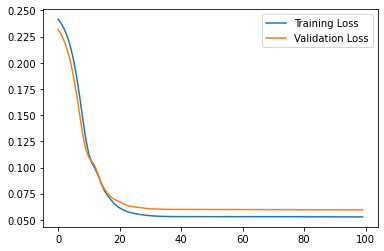

In [33]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

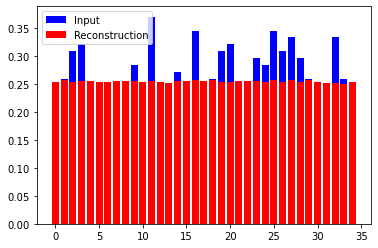

In [34]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.bar(np.arange(35),normal_test_data[0], color='blue')
plt.bar(np.arange(35),decoded_data[0], color='red')
#plt.fill_between(np.arange(35), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

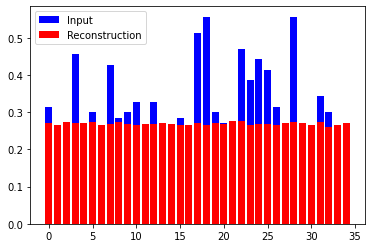

In [19]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.bar(np.arange(35),anomalous_test_data[0], color='blue')
plt.bar(np.arange(35),decoded_data[0], color='red')
#plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

64/64 [==============================] - 0s 2ms/step


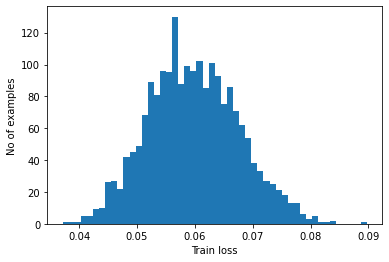

In [20]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
#valeur moyenne de l'erreur

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
#ce qui est à droite:anomalie

Threshold:  0.06756108


17/17 [==============================] - 0s 2ms/step


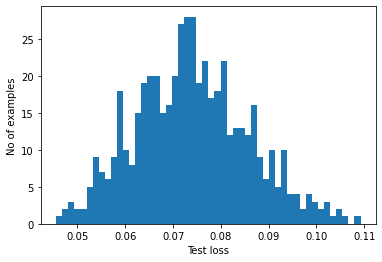

In [22]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [23]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [24]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.756
Precision = 0.7117117117117117
Recall = 0.824634655532359
